In [63]:
'''
# Check if these need to be installed
pip install wget
pip install requests
pip install azure-cognitiveservices-search-imagesearch
'''

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=d91dd9b1febaa6ab3bad01dad180e8e13eca892a132f17923b3ef241a74cf5e6
  Stored in directory: /Users/mton/Library/Caches/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [54]:
import os as os
from requests import request
# request('GET','http://localhost:5000/')
# TODO : Fix this trash => Ugh, hardcoding my key for now lol
key = os.environ.get('AZURE_SEARCH_KEY', '2414bd8a0aaa4f609964be7106a58890')

In [15]:

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
from fastai.vision.core import L #foundation.py

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = request('GET', search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()
#      for each in search_results['value']:
#            print(each)
     return L(search_results['value'])

In [60]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
from wget import download
dest = 'images/grizzly.jpg'
isdir = os.path.isdir(dest)
print(isdir)
dir = download(ims[0])
print(dir)

im = Image.open(dir)  # type: ignore
im.to_thumb(128, 128)

In [32]:
from fastai.vision.utils import download_images
from fastcore.utils import Path

bear_types = 'grizzly', 'black', 'teddys'
path = Path('Bears')
print(path)
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Bears


In [33]:
from fastai.vision.utils import get_image_files, verify_images

print(bear_types)
path = Path('Bears')
fns = get_image_files(path)
# originally 384 imaged - UPDATE manually removed one image => 383
print(len(fns.items))
# Some downloads will be corrupt, let's check for them
failed = verify_images(fns)
print(len(failed.items))
# Some downloads will be corrupt, let's check for them
# 328 after removing 56 corrupt images - UPDATE manually removed one image => 327
failed.map(Path.unlink)
print(len(fns.items))

('grizzly', 'black', 'teddys')
327
0
327


In [34]:
from fastai.vision.utils import DataBlock, CategoryBlock, get_image_files, RandomSplitter, parent_label
from fastai.vision.data import ImageBlock
from fastai.vision.augment import Resize

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),   # type: ignore
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # set seed so that the 20% validation data is always the same
    get_y=parent_label, # y is the label, i.e. the dependent variable to x
    item_tfms=Resize(128)  # type: ignore : tensors have to be the same size, Preprocess and Resize to 128x128
)

dls = bears.dataloaders(path)

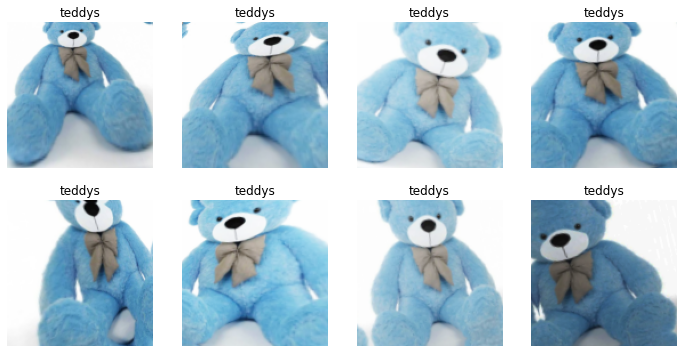

In [35]:
from fastai.vision.augment import aug_transforms
from fastai.vision.augment import RandomResizedCrop

# data augmentation - randomnly transform, warp, brighten, contrast ... etc
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),   # type: ignore
    batch_tfms=aug_transforms(mult=2)
)

dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [36]:
from fastai.vision.learner import vision_learner
from fastai.vision.learner import error_rate
from fastai.vision.models import resnet50, ResNet50_Weights
# from fastai.vision.models import resnet18, ResNet18_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)
learn = vision_learner(dls, resnet50, metrics=error_rate)

# TODO : Learn and explain the difference bewtween resenet50 and resnet18
# resnet18(weights=ResNet18_Weights.DEFAULT)
# learn = vision_learner(dls, resnet18, metrics=error_rate)


/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
from fastai.vision.learner import Learner
from fastai.vision.all import *

learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.054335,0.116386,0.046154,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.135657,0.057235,0.030769,00:45
1,0.189048,0.143738,0.030769,00:40
2,0.184205,0.077887,0.015385,00:40
3,0.149018,0.061923,0.015385,00:39


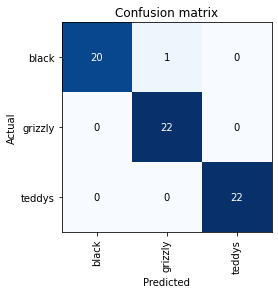

In [38]:
from fastai.vision.learner import ClassificationInterpretation

# Use fastai tool to measure early model results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


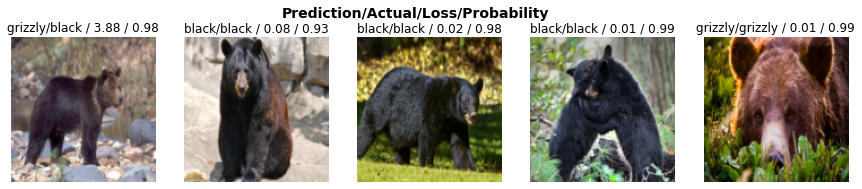

In [47]:
# Show the top 5 most confused images and manually check their labels
# This is a benefit of standing up a rough model quickly FIRST
# and then MANUALLY checking the results AFTERWARDS : much more efficient
interp.plot_top_losses(5, nrows=1)

In [42]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [58]:
print(f"cleaner >> count {len(cleaner.fns.items)}")

# delete teddy bear images with children occluding the foreground and black/grizzly bears mixed in
print(f"cleaner >> delete {len(cleaner.delete())}")
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

print(f"cleaner >> changed {len(cleaner.change())}")
for idx,cat in cleaner.change():
    print(f"cleaner >> id {idx} cat {cat}")
    shutil.move(str(cleaner.fns[idx]), path/cat)   # type: ignore 

cleaner >> count 21
cleaner >> delete 0
cleaner >> changed 1
cleaner >> id 0 cat grizzly


In [60]:
print(f"cleaner >> delete {len(cleaner.delete())}")
print(f"cleaner >> count {len(cleaner.fns.items)}")
print(f"cleaner >> changed {len(cleaner.change())}")


cleaner >> delete 0
cleaner >> count 21
cleaner >> changed 1
